In [2]:
import gentrl
import torch
from rdkit.Chem import Draw
from moses.metrics import mol_passes_filters, QED, SA, logP
from moses.metrics.utils import get_n_rings, get_mol

torch.cuda.set_device(0)

In [1]:
import torch
from torch import nn
from gentrl.tokenizer import encode, get_vocab_size

class CNNEncoder(nn.Module):
    def __init__(self, hidden_size=256, latent_size=50):
        super(CNNEncoder, self).__init__()

        self.embs = nn.Embedding(get_vocab_size(), hidden_size)
        self.cnn = nn.Conv1d(50,50,1)

        self.final_mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size), nn.LeakyReLU(),
            nn.Linear(hidden_size, 2 * latent_size))

    def encode(self, sm_list):

        tokens, lens = encode(sm_list)
        to_feed = tokens.transpose(1, 0).to(self.embs.weight.device)

        outputs = self.cnn(self.embs(to_feed))
        outputs = self.cnn(outputs)

        outputs = outputs[lens, torch.arange(len(lens))]

        return self.final_mlp(outputs)

RDKit WARNING: [02:23:41] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
enc = CNNEncoder(latent_size=50)
dec = gentrl.DilConvDecoder(latent_input_size=50)
model = gentrl.GENTRL(enc, dec, 50 * [('c', 20)], [('c', 20)], beta=0.001)
model.cuda();

In [2]:
# enc = gentrl.RNNEncoder(latent_size=50)
# dec = gentrl.DilConvDecoder(latent_input_size=50)
# model = gentrl.GENTRL(enc, dec, 50 * [('c', 20)], [('c', 20)], beta=0.001)
# model.cuda();

In [4]:
model.load('saved_gentrlCNN_after_rl/')
model.cuda();

In [5]:
enc

CNNEncoder(
  (embs): Embedding(28, 256)
  (cnn): Conv1d(50, 50, kernel_size=(1,), stride=(1,))
  (final_mlp): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=100, bias=True)
  )
)

In [6]:
dec

DilConvDecoder(
  (latent_fc): Linear(in_features=50, out_features=128, bias=True)
  (input_embeddings): Embedding(28, 128)
  (logits_1x1_layer): Conv1d(128, 28, kernel_size=(1,), stride=(1,))
  (parameters): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 28x128 (GPU 0)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 28x128x1 (GPU 0)]
      (2): Parameter containing: [torch.cuda.FloatTensor of size 28 (GPU 0)]
      (3): Parameter containing: [torch.cuda.FloatTensor of size 128x50 (GPU 0)]
      (4): Parameter containing: [torch.cuda.FloatTensor of size 128 (GPU 0)]
      (5): Parameter containing: [torch.cuda.FloatTensor of size 128 (GPU 0)]
      (6): Parameter containing: [torch.cuda.FloatTensor of size 128 (GPU 0)]
      (7): Parameter containing: [torch.cuda.FloatTensor of size 128x128x1 (GPU 0)]
      (8): Parameter containing: [torch.cuda.FloatTensor of size 128 (GPU 0)]
      (9): Parameter containing: [torch.cuda.FloatTensor o

In [7]:
def get_num_rings_6(mol):
    r = mol.GetRingInfo()
    return len([x for x in r.AtomRings() if len(x) > 6])


def penalized_logP(mol_or_smiles, masked=True, default=-5):
    mol = get_mol(mol_or_smiles)
    if mol is None:
        return default
    reward = logP(mol) - SA(mol) - get_num_rings_6(mol)
    if masked and not mol_passes_filters(mol):
        return default
    return reward

In [8]:
generated = []

while len(generated) < 100:
    sampled = model.sample(1000)
    sampled_valid = [s for s in sampled if get_mol(s)]
    
    generated += sampled_valid

RDKit ERROR: [02:24:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 18 19
RDKit ERROR: 
RDKit ERROR: [02:24:40] SMILES Parse Error: extra close parentheses while parsing: N3ccccc2NC(=O)c2cncnc2)c(Br)cc1
RDKit ERROR: [02:24:40] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: no atoms
RDKit ERROR: Violation occurred on line 173 in file /opt/conda/conda-bld/rdkit_1578628738519/work/Code/GraphMol/ROMol.cpp
RDKit ERROR: Failed Expression: getNumAtoms() > 0
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [02:24:40] SMILES Parse Error: extra open parentheses for input: 'CCOc1cc(OC(=O)C(O)Cc1cc2c(cc1F)CC2'
RDKit ERROR: [02:24:40] SMILES Parse Error: extra open parentheses for input: 'O=C(CN1C(=O)CN1C(=O)C1Oc1ccco1'
RDKit ERROR: [02:24:40] SMILES Parse Error: extra open parentheses for input: 'COC(=O)c1cc(C#N)cc(C(=O)n1ccncc1'
RDKit ERROR: [02:24:40] SMILES Parse Error: extra open parentheses for input: 'N#CCc1cc(C2cc(Cl)ccc3nc(C)ccc1Br'
RDKit ERROR: [02:24:

/opt/conda/envs/my-rdkit-env/lib/python3.6/site-packages/rdkit/Chem/Draw/IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


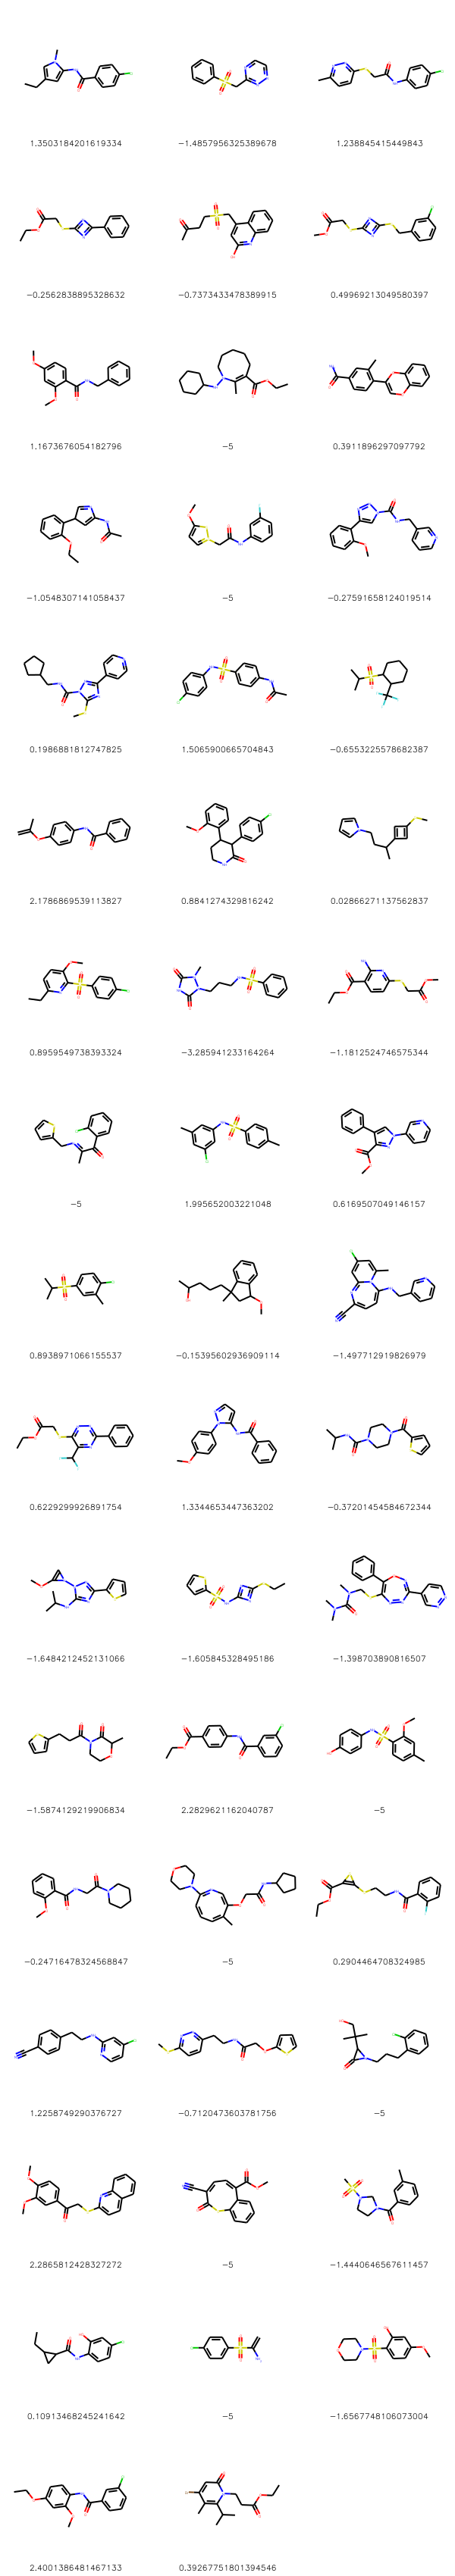

In [9]:
Draw.MolsToGridImage([get_mol(s) for s in sampled_valid], 
                     legends=[str(penalized_logP(s)) for s in sampled_valid])